In [2]:
import cirq_google
import cirq
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_quantum as tfq

import sympy
import random
from itertools import product

from cirq.contrib.svg import SVGCircuit

# III:

## a: Quantum autoencoder

### Data Preperation

In [38]:
data = np.load('electron-photon.npz', allow_pickle=True)
IMAGE_SIZE = 2

To spare computational resources I downscale the images.  
On my machines I only managed to effectively train models with 3x3 images, otherwise my computer crashed. I guess this is probabily, because I use many qubits for a single image by encoding one pixel with one qubit, especially together with the swap test.   
In this notebook I only use an image size of 2 for finite training times, the results for 3x3 images were very similar.    
Future work might explore the use of FRQI or NEQR for more efficent encoding, but I wasnt able to produce a working version within the time given.

In the future I would explore hybrid networks where e.g. a cnn extracts features from the images which get fed into the QAE.

In [39]:
x_train_scale = tf.image.resize(data['x_train'][...,np.newaxis], (IMAGE_SIZE,IMAGE_SIZE), method="lanczos5").numpy()
x_test_scale = tf.image.resize(data['x_test'][...,np.newaxis], (IMAGE_SIZE,IMAGE_SIZE), method="lanczos5").numpy()

For the sake of simplicity, for my first model, i convert the images to black (0) and white (1).  
Again a more sophisticated model should use FRQI or NEQR exploit the full information of the dataset by encoding the grayscales.
I use 0 as threshold as otherwise most images are just black.

In [40]:
x_train = np.array(x_train_scale > 0, dtype=np.float32)
y_train = data['y_train']
x_test = np.array(x_test_scale > 0, dtype=np.float32)
y_test = data['y_test']

print(x_train.shape)
print(x_test.shape)

(100, 2, 2, 1)
(100, 2, 2, 1)


To my understanding I would now train the autoencoder e.g. only on the electron samples and test if i can classify photon using the reconstruction error or fidelity.
Therefore for X_train I will only use electrons. X_test will only consist of electrons as well to check the fidelity of unseen examples.
I seperate the photon samples for later checks of the anomaly score

In [41]:
x_photon = x_train[y_train == 0]
x_train = x_train[y_train == 1]
x_photon_test = x_test[y_train == 0]
x_test = x_test[y_train == 1]

An example of an electron

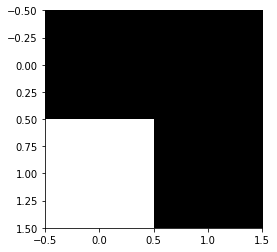

In [43]:
plt.imshow(x_train[13,:,:,0],cmap='Greys_r')

Convert to qbits by applying an X gate on every active pixel (1).  
The other pixels (0) get an unchanged qbit.

In [44]:
def img_to_circuit(image):
    flat_data = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(IMAGE_SIZE, IMAGE_SIZE)
    c = cirq.Circuit()
    for idx, val in enumerate(flat_data):
        if val:
            c.append(cirq.X(qubits[idx]))
    return c


x_train_cdata = [img_to_circuit(x) for x in x_train]
x_test_cdata = [img_to_circuit(x) for x in x_test]

sample curcuit

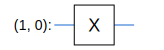

In [46]:
SVGCircuit(x_train_cdata[13])

Prepare Data for tf

In [47]:
x_train_tf = tfq.convert_to_tensor(x_train_cdata)
x_test_tf = tfq.convert_to_tensor(x_test_cdata)

### The model

For my first try on QML I wanted to implement a simple autoencoder.
The idea for training stems from 1612.02806 and is loosely explained in https://www.youtube.com/watch?v=ju4B0t25Ky8

After adding the layers for the encoder and decoder network a swap test is performed to measure the fidelity between input and output.
The output of the swap test can then be used for training using a simple mean absolute error as loss where 1 is used as label for all samples to compute the inaccuracy in reconstruction.

Build the autoencoder circuit:  
one layer is build up from cnot between qbits and ry and rz rotations for training parameters.
Using y\*\*params instead of the ry gate should be equivalent up to a phase

In [48]:
def layer(qs, params):
    circ = cirq.Circuit()
    for i in reversed(range(len(qs)-1)):
        circ += cirq.CNOT(qs[i], qs[i+1])
    for i in range(len(qs)):
        circ += cirq.ry(params[2*i]).on(qs[i])
        circ += cirq.rz(params[2*i + 1]).on(qs[i])
    return circ

example for one layer

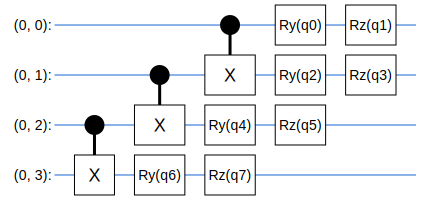

In [49]:
SVGCircuit(layer(cirq.GridQubit.rect(1, 4),sympy.symbols("q0:%d"%50)))

The full autoencoder consists of arbitrary many layers for the encoder followed by the same number of layers for the decoder.
The encoder and decoder qbits overlap only at the latent space qbits.

After the actual autoencoder networks the swap test is performed.

In [50]:
def make_circuit(qs, state, latent, params, depth, swap_qubit, reference_qubits):
    c = cirq.Circuit()
    enc_params = params[:len(params) // 2]
    dec_params = params[len(params) // 2:]
    for i in range(depth):
        c += layer(qs[:state], enc_params[2 * i * state:2 * (i + 1) * state])
    for i in range(depth):
        c += layer(qs[state - latent:], dec_params[2 * i * state:2 * (i + 1) * state])
    # SWAP Test
    c += cirq.H(swap_qubit)
    for i, j in product(range(state), range(state - latent, len(qs))):
        c += cirq.ControlledGate(sub_gate=cirq.SWAP, num_controls=1).on(swap_qubit, reference_qubits[i], qs[j])
    c += cirq.H(swap_qubit)
    return c

The state qbits are the qbits for the input data.
Since I already heavily reduced the size of the images, I choose to only use a single latent qbit.
The total qbits needed for the encoder and decoder networks are twice the qbits needet for the data minus the latent qbits since they overlap between the two networks

In [51]:
state_qubits = IMAGE_SIZE*IMAGE_SIZE
latent_qubits = 1
network_qubits = state_qubits + (state_qubits - latent_qubits)

qubits = [cirq.GridQubit(0, i) for i in range(network_qubits + 1 + state_qubits)]
print(len(qubits))

12


In [52]:
layers = 2

num_params = 4 * state_qubits * layers
parameters = sympy.symbols("q0:%d"%num_params)

build the keras model.
the redout operator acts on the first qbit after the ae networks where the swap test is performed.
The y data are just ones so that a mean average errer can be used to compute 1 - fidelity using the swap test output.

In [60]:
c = make_circuit(qubits[:network_qubits], state_qubits, latent_qubits, parameters, layers, qubits[network_qubits], qubits[network_qubits + 1:])
readout_operators = [cirq.Z(qubits[network_qubits])]
inputs = tf.keras.Input(shape=(), dtype=tf.dtypes.string)
layer1 = tfq.layers.PQC(c, readout_operators, differentiator=tfq.differentiators.Adjoint())(inputs)
autoencoder = tf.keras.models.Model(inputs=inputs, outputs=layer1)
autoencoder.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(lr=0.1))
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

y_train = np.ones(shape=len(x_train_tf))
y_test = np.ones(shape=len(x_test_tf))

show the whole circuit

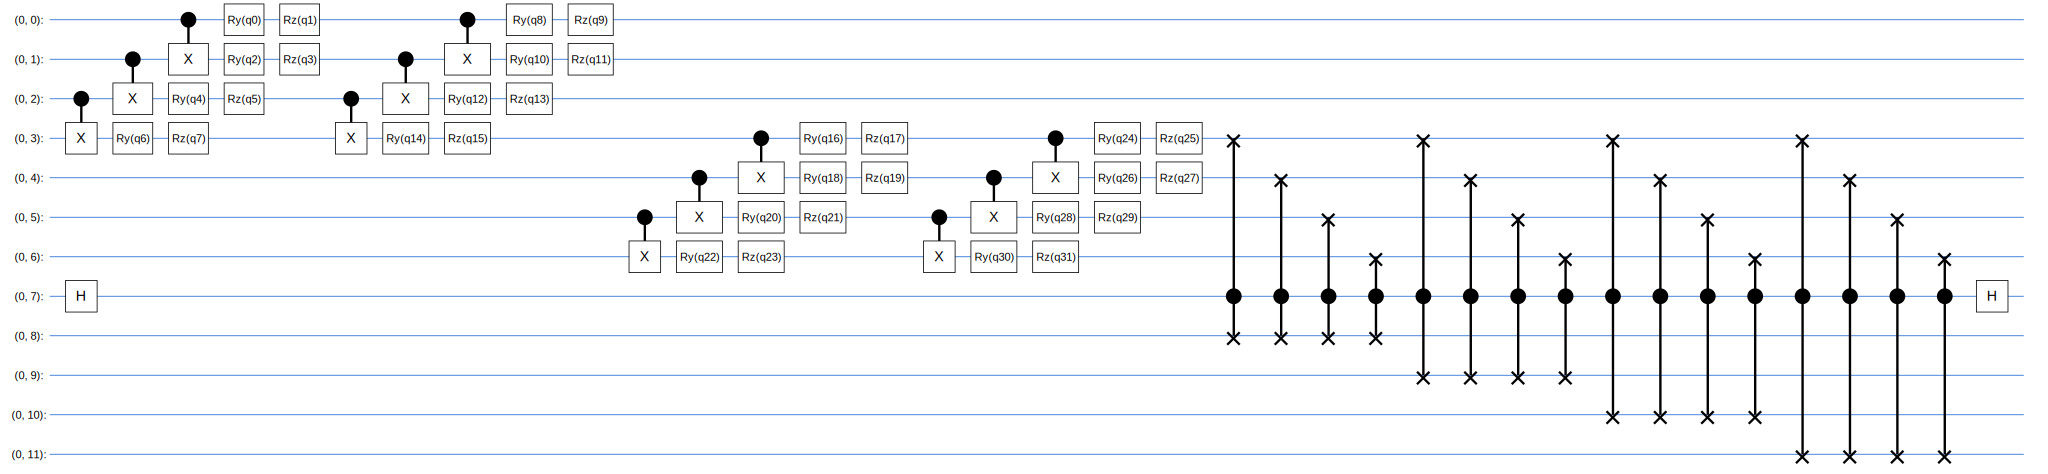

In [57]:
SVGCircuit(c)

For faster training you might reduce the dataset.  
Use cutoff = 56 for full data

In [61]:
CUTOFF = 56

x_train_tf_s = x_train_tf[:CUTOFF]
x_test_tf_s = x_test_tf[:CUTOFF]
y_train_s = y_train[:CUTOFF]
y_test_s = y_test[:CUTOFF]

In [62]:
history = autoencoder.fit(x_train_tf_s, y_train_s, epochs=50, batch_size=14, validation_data=(x_test_tf_s, y_test_s), callbacks=[es])

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
4/4 [==============================] - ETA: 0s - loss: 0.7876WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f7142bf65f0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full outpu

As we can see the fidelity approaches 1, which shows that the reconstruction of electrons is successfull

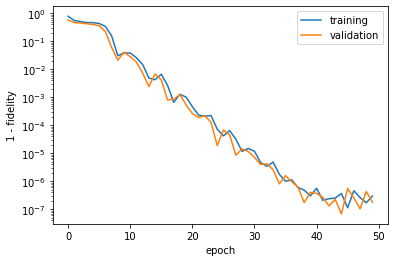

In [64]:
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("1 - fidelity")
plt.yscale('log')
plt.show()